Imports

In [33]:
from catheter_utils import geometry  
from catheter_utils import cathcoords
from catheter_utils import metrics
from operator import add
import dicom_utils
import dicom_art
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
import glob
import os
import pydicom as dicom
import pandas as pd

import scipy.stats as stats

%matplotlib inline

Heatmap Function

In [34]:
##### Heatmap ######
def nonuniform_imshow(x, y, z, aspect = 1, cmap = plt.cm.rainbow):
    # Create regular grid
    xi, yi = np.linspace(x.min() - 16.6, x.max() + 16.6, 4), np.linspace(y.min() - 16.6, y.max() + 16.6, 4)
    xi, yi = np.meshgrid(xi, yi)

    norm = plc.Normalize(vmin = 0, vmax = 5)
    interp = scipy.interpolate.NearestNDInterpolator(list(zip(x, y)), z)
    zi = interp(xi, yi)

    fig, ax = plt.subplots(figsize=(12, 8))

    hm = ax.imshow(zi, interpolation = 'nearest', cmap = cmap, norm = norm, extent = [x.min() - 16.6, x.max() + 16.6, y.max() + 16.6, y.min() - 16.6])
    ax.scatter(x, y, c = 'k')
    ax.set_aspect(aspect)
    return hm

Constants and Paths

In [35]:
# Main data paths for each catheter (manually input)
parent_path = '../data/processed'
main_path_222 = parent_path + '/static/trackTest-17Aug2021-C222-Y0/'
main_path_231 = parent_path + '/static/trackTest-15Dec2021-C231-Y0/'
main_path_306 = parent_path + '/static/trackTest-13Dec2021-C306-Y0/'

main_path = [main_path_222, main_path_231, main_path_306]

# Where you would like to save the heatmaps (manually input)
heatmap_path = '../reports/figures/static/Y45mm/'

alg = 'jpng'

Gt_filename = '1GroundTruthCoords.csv'

geometry_index = 1

Get CP3 Data

In [36]:
def get_catheter_data(main_path, sequence, algorithm, geometry_index=1):
    # Get data for each catheter
    path_dct = {}

    for path in main_path:

        coords = []

        # Register every bias (16 in this case)
        for i in range(16):

            # Get ground truth info for each point
            Gt_path = path + str(i + 1) + '/' + Gt_filename
            Gt_file = open(Gt_path, 'r')
            reader = Gt_file.readlines()
            distal_gt = []
            proximal_gt = []

            for line in reader[1:]:
                data = line.split(',')
                if (data[-2].strip() == 'dist'):
                    distal_gt.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
                    distal_gt = np.array(distal_gt)
                    distal_index = int(data[-1].strip())

                elif (data[-2].strip() == 'prox'):
                    proximal_gt.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
                    proximal_gt = np.array(proximal_gt)
                    proximal_index = int(data[-1].strip())

            # Determine coil geometry for each point
            geo = geometry.GEOMETRY[geometry_index]
            fit = geo.fit_from_coils_mse(distal_gt, proximal_gt)
            tip_gt = fit.tip

            # Choose relevant sequence directory
            directories = [f.name for f in os.scandir(path + str(i + 1) + '/') if f.is_dir()]
            for directory in directories:
                if directory.startswith(sequence):
                    curr_dir = path + str(i + 1) + '/' + directory + '/'

            # Get error data for current point
            cathcoord_files = cathcoords.discover_files(curr_dir + alg + '/')

            if bool(cathcoord_files) == True:
                distal_file = cathcoord_files[0][distal_index]    
                proximal_file = cathcoord_files[0][proximal_index]

                bias = metrics.Bias(distal_file, proximal_file, tip_gt, geo)

                coords.append([tip_gt[0][0], tip_gt[0][2], bias])

            else:
                coords.append([tip_gt[0][0], tip_gt[0][2], 0])

        coords = np.array(coords)

        path_dct[path] = coords
    return path_dct


Generate CP3 Heatmap

In [37]:
seq = 'SRI_Original'

# Average the error
path_dct = get_catheter_data(main_path, seq, alg, geometry_index)
avg_all_caths = (path_dct[main_path_222] + path_dct[main_path_231] + path_dct[main_path_306]) / 3
avg_err = avg_all_caths[:, 2]
my_data = np.array([avg_all_caths[:, 0], avg_all_caths[:, 1], avg_err]).T

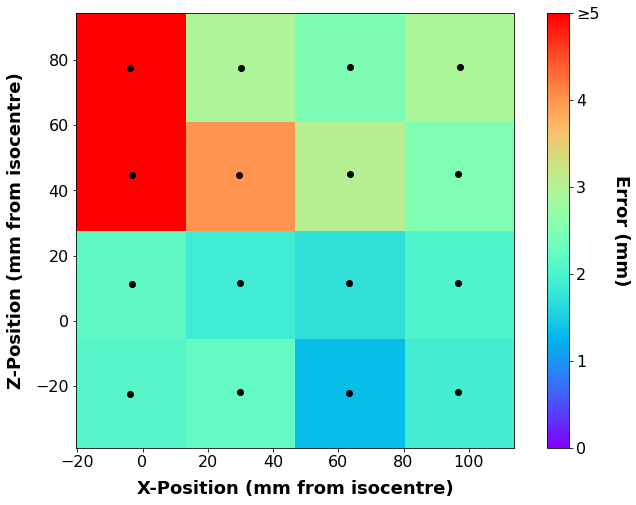

In [38]:
X = my_data[:, 0]
Y = my_data[:, 1]
Z = my_data[:, 2]

heatmap = nonuniform_imshow(X, Y, Z)
plt.gca().invert_yaxis()
plt.xlabel('X-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
plt.ylabel('Z-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title('Tip Tracking Error @ Y = 45mm (Conventional Sequence)'.format(seq, alg), fontsize = 18, fontweight = "bold")
cbar = plt.colorbar(heatmap)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '\u2265' + '5'])
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.tick_params(labelsize = 16) 
cbar.ax.set_ylabel('Error (mm)', rotation = 270, fontsize = 18, fontweight = 'bold')

if not os.path.isdir('{0}'.format(heatmap_path)):
    os.makedirs('{0}'.format(heatmap_path))
    
plt.savefig('{0}{1}_heatmap.png'.format(heatmap_path, seq), dpi=300)

Get Hadamard Data

In [39]:
seq = 'FH512_noDither_gradSpoiled'

path_dct = {}

path_dct = get_catheter_data(main_path, seq, alg, geometry_index)
# Average the error
avg_all_caths = (path_dct[main_path_222] + path_dct[main_path_231] + path_dct[main_path_306]) / 3
avg_err = avg_all_caths[:, 2]
my_data = np.array([avg_all_caths[:, 0], avg_all_caths[:, 1], avg_err]).T

Generate Hadamard Heatmap

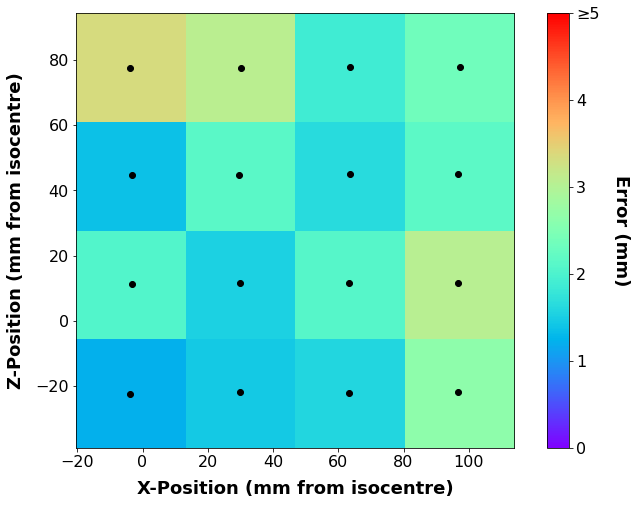

In [40]:
X = my_data[:, 0]
Y = my_data[:, 1]
Z = my_data[:, 2]

heatmap = nonuniform_imshow(X, Y, Z)
plt.gca().invert_yaxis()
plt.xlabel('X-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
plt.ylabel('Z-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title('Tip Tracking Error @ Y = 45mm (Hadamard Multiplexed Sequence)'.format(seq, alg), fontsize = 18, fontweight = "bold")
cbar = plt.colorbar(heatmap)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '\u2265' + '5'])
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.tick_params(labelsize = 16) 
cbar.ax.set_ylabel('Error (mm)', rotation = 270, fontsize = 18, fontweight = 'bold')

if not os.path.isdir('{0}'.format(heatmap_path)):
    os.makedirs('{0}'.format(heatmap_path))
    
plt.savefig('{0}{1}_heatmap.png'.format(heatmap_path, seq), dpi=300)